# CL distribution FALKNER table 26
Based on data from "Calculated loadings due to incidence of a number of straight and swept-back wings", V.M. Falkner 1948:
https://reports.aerade.cranfield.ac.uk/handle/1826.2/3122?show=full

In [1]:
import numpy as np

AR = 2
half_wing_span = 0.5
sweep_angle_deg = 30.
chord_length = (2 * half_wing_span) / AR
AoA_deg = 4.

# dcl/dalpha
a_ref = 2.480
# eta = 2y/b, b= 2 * half_winf_span
x_good = np.arange(0., 1.05, 0.05) # from 0 to 1!
# Cll/Cl local lift coefficient
y_good = np.array([1.226, 1.225, 1.222, 1.218, 1.211, 1.202, 1.190, 1.176, 1.158, 1.136, 1.109, 1.078, 1.040, 0.995, 0.942, 0.878, 0.801, 0.707, 0.587, 0.422, 0.])

# 126-vortex 6 point standart solution modified: auxiliary siolution
n_spanwise = len(y_good) 
n_chordwise = int(126 / n_spanwise) # 1 

cav = chord_length # for sweep wing: are of wing = b * c, average chord is equal to chord length

In [2]:
# varaibles.py for jupyter
import os
import numpy as np
import time
from pySailingVLM.runner.container import Output, Rig, Conditions, Solver, MainSail, JibSail, Csys, Keel

mgirths =  np.array([0.00, 1./8, 1./4, 1./2, 3./4, 7./8, 1.00])
mchords = np.array([chord_length]* len(mgirths))

   
out = Output(case_name='my_case_name',
             case_dir=os.path.abspath(''),
             name=os.path.join("results_example_jib_and_mainsail_vlm", time.strftime("%Y-%m-%d_%Hh%Mm%Ss")),
            file_name='my_fancy_results')

solver = Solver(n_spanwise=n_spanwise,
                n_chordwise=n_chordwise,
                interpolation_type='linear')

conditions = Conditions(leeway_deg=0.,    
                        heel_deg=0.,    
                        SOG_yacht=0.,  
                        tws_ref= 1.,     
                        alpha_true_wind_deg= AoA_deg, 
                        reference_water_level_for_wind_profile=-0.,
                        wind_exp_coeff=0.,
                        wind_reference_measurment_height=10.,
                        rho=1.,
                        wind_profile='flat',
                        roughness=0.05)

rig = Rig(main_sail_luff=half_wing_span / np.cos(np.deg2rad(sweep_angle_deg)),
          jib_luff=10.0,
          foretriangle_height=11.50,
          foretriangle_base=3.90,
          sheer_above_waterline=0.,
          boom_above_sheer=0.,
          rake_deg=90. + sweep_angle_deg,
          mast_LOA=0.,
          sails_def='main')

main = MainSail(centerline_twist_deg=0*mgirths,
                girths=mgirths,
                chords=mchords,
                camber= 0*np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
                camber_distance_from_luff=np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]))
  

# not used in this example becouse sails_def is only main
jgirths = np.array([0.00, 1./4, 1./2, 3./4, 1.00])
jib = JibSail(centerline_twist_deg=0*jgirths,
             girths=jgirths,
             chords=0* np.array([3.80, 2.98, 2.15, 1.33, 0.5]),
             camber=0*np.array([0.01, 0.01, 0.01, 0.01, 0.01]),
             camber_distance_from_luff=np.array([0.5, 0.5, 0.5, 0.5, 0.5]))

csys = Csys(reference_level_for_moments=np.array([0, 0, 0]))
keel = Keel(center_of_lateral_resistance_upright=np.array([0, 0, -1.0]))    


<div class="alert alert-block alert-warning">
<b>Run cell below twice:</b> Run cell below twice before running other cells. Output below is expected to always appear at first time importing pySailingVLM:
<br><br>
    
<em>   
/home/user/miniconda3/envs/mgr_test/lib/python3.10/site-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function __numba_array_expr_0x7f01d6a1e9e0 at 0x7f01d6cfa680>. Debug line information may be inaccurate.warnings.warn(NumbaDebugInfoWarning(msg))
</em> 
<br>
</div>

In [3]:
import shutil
from pySailingVLM.rotations.csys_transformations import CSYS_transformations
from pySailingVLM.yacht_geometry.hull_geometry import HullGeometry
from pySailingVLM.results.save_utils import save_results_to_file
from pySailingVLM.solver.panels_plotter import display_panels_xyz_and_winds
from pySailingVLM.results.inviscid_flow import InviscidFlowResults
from pySailingVLM.solver.vlm import Vlm
from pySailingVLM.runner.sail import Wind, Sail
from pySailingVLM.runner.container import Output, Rig, Conditions, Solver, MainSail, JibSail, Csys, Keel

from pySailingVLM.solver.panels_plotter import plot_cp

In [4]:
import numpy as np
from pySailingVLM.solver.coefs import get_vlm_Cxyz

csys_transformations = CSYS_transformations(conditions.heel_deg, conditions.leeway_deg, v_from_original_xyz_2_reference_csys_xyz=csys.reference_level_for_moments)
w = Wind(conditions)
s = Sail(solver, rig, main, jib, csys_transformations)
sail_set = s.sail_set
myvlm = Vlm(sail_set.panels, solver.n_chordwise, solver.n_spanwise, conditions.rho, w.profile, sail_set.trailing_edge_info, sail_set.leading_edge_info)
height = 1.0

In [5]:
from pySailingVLM.solver.coefs import get_C
cl = get_C(myvlm.panels, myvlm.areas, myvlm.lift, myvlm.inlet_conditions.V_app_infs, myvlm.n_spanwise, myvlm.n_chordwise, myvlm.rho)
cd = get_C(myvlm.panels, myvlm.areas, myvlm.drag, myvlm.inlet_conditions.V_app_infs, myvlm.n_spanwise, myvlm.n_chordwise, myvlm.rho)

In [6]:
k = int(myvlm.panels.shape[0] / (solver.n_spanwise * solver.n_chordwise * 2) ) # *2 in denominator due to underwater part


sail_areas = np.split(myvlm.areas, (2*k))
section_areas = np.zeros((k, solver.n_spanwise), dtype=float) # reshaped in proper way array with areas
sail_cps = np.split(myvlm.cp, (2*k))
sail_section_mean_cp_z = np.zeros((k, solver.n_spanwise), dtype=float)
# cl for every panel in all sails

# iterating only above water
for i in range(k):
    for j in range(solver.n_spanwise):   
        section_sail_areas = sail_areas[i].reshape(solver.n_chordwise, solver.n_spanwise)[:,j]
        section_areas[i, j] = np.sum(section_sail_areas)
        
        arr = sail_cps[i][:, 2].reshape(solver.n_chordwise, solver.n_spanwise).transpose()
        mean_section_cp_z = np.sum(arr, axis=1) / solver.n_chordwise
        sail_section_mean_cp_z[i] = mean_section_cp_z

In [7]:
CL = np.sum(section_areas[0] * cl[0]) / np.sum(section_areas[0])
a_vlm = CL / np.deg2rad(AoA_deg)

In [8]:
print(f"dcl\dalpha:\t {a_vlm}\t theory: {a_ref}") # dla n_chordwise = 1 wynik jest zblizony do teorii, 
# jak jest więcej paneli chordiwe to bardziej odvhodzimy od prawdy. Dlaczego ????


dcl\dalpha:	 2.4469471553797204	 theory: 2.48


In [9]:
from pySailingVLM.solver.panels_plotter import plot_cp
plot_cp(sail_set.zero_mesh, myvlm.p_coeffs, out.name)

Loading BokehJS ...

In [10]:
y_data = cl[0] / CL
x_data  = 2*sail_section_mean_cp_z[0] / (2*half_wing_span)

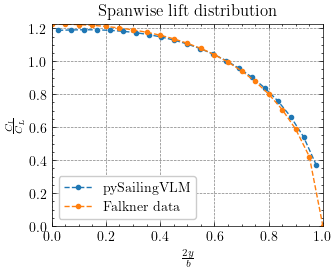

In [13]:
import matplotlib.pyplot as plt
import scienceplots # sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

plt.style.use(['science', 'grid'])
from matplotlib import pyplot as plt
fig = plt.figure()

section_number = np.arange(1, myvlm.n_spanwise+1, 1)
ax = fig.add_subplot(1, 1, 1)

ax.plot(x_data, y_data, '--.', color='tab:blue', label='pySailingVLM')
ax.plot(x_good, y_good, '--.', color='tab:orange', label='Falkner data')


ax.set_xlabel(r"$\frac{2y}{b}$")
ax.set_ylabel(r"$\frac{C_{l}}{C_{L}}$")
ax.set_title("Spanwise lift distribution")
ax.legend()   
ax.autoscale(tight=True)
plt.savefig('falkner_26', dpi=300)